<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ds5110/summer-2021/blob/master/05c-flights-intro.ipynb">
<img src="https://github.com/ds5110/summer-2021/raw/master/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>


# 5c -- flights intro

Case study: [nycflights13 dataset](https://github.com/tidyverse/nycflights13) -- larger multi-table database with ER diagram.

### References

* [R4DS -- Ch 15: Relational data](https://r4ds.had.co.nz/relational-data.html) -- r4ds.had.co.nz
  * Original data source: [Bureau of Transportation Statistics](https://www.bts.gov/) -- bts.gov
* [sqlite3](https://docs.python.org/3/library/sqlite3.html) API reference -- python.org


In [1]:
import sqlite3
import pandas as pd

# From sqlite3 to pandas

* [Reading tables](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#reading-tables) -- pandas.pydata.org
* [`pandas.read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql_table.html#pandas.read_sql_table) -- pandas.pydata.org
  * SQLAlchemy provides database abstraction if it's installed.
* [`read_sql_table` needs SQLAlchemy](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#reading-tables) -- pandas.pydata.org
  * SQLite is in Python’s standard library by default. 
  * You will need a driver library for other databases. 
    * [psycopg2](https://www.psycopg.org/) for PostgreSQL
    * [pymysql](https://github.com/PyMySQL/PyMySQL) for MySQL
* [SQL queries with pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-sql)
* [write dataframe to sqlite3](https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index) -- stackoverflow

# Load a database with pandas

* [.to_sql()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html) API reference docs -- pandas.pydata.org
  * Support is provided for sqlite3.Connection objects. 
  * For another RDBMS, use SQLAlchemy.
* [SQLAlchemy](https://docs.sqlalchemy.org/en/13/core/connections.html)
  * SQLAlchemy makes it possible to use any DB supported by that library. 
  * You are responsible for engine disposal and connection closure when using SQLAlchemy.



## Big data considerations

* Pandas doesn't ["scale" to large datasets](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html)
  * Pandas provides data structures for in-memory analytics
  * For large datasets, you need a parallelization strategy and an appropriate tool.
* [Parquet](https://parquet.apache.org/) works when big problems can divided into chunks
    * Each chunk involves a file that fits into memory
* [Dask](https://dask.org/) has a dataframe API similar to Pandas
    * Dask can use multithreading
    * Dask can scale to distribute jobs on clusters
    * Dask is not subject to the Python Global Interpreter Lock (GIL)


# nycflights13 dataset

* flights departing NYC in 2013
* [tidyverse github site](https://github.com/tidyverse/nycflights13/raw/master/data-raw/) -- doesn't have a `flights.csv`
* [R script chat creates flights table](https://github.com/tidyverse/nycflights13/blob/master/data-raw/flights.R) -- github
* The script shows (reproducibly) how to recreate the table.
* The script points to the authoritative data source (bts.gov)
* Infinitely better than simply posting a CSV file!

In [2]:
base = "http://pbogden.github.io/ds5110/data/nycflights13/"
flights = pd.read_csv(base + "flights.csv").drop("Unnamed: 0", axis=1)
airlines = pd.read_csv(base + "airlines.csv").drop("Unnamed: 0", axis=1)
weather = pd.read_csv(base + "weather.csv").drop("Unnamed: 0", axis=1)

flights

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,2013,9,30,NaN,1455,NaN,NaN,1634,NaN,9E,3393,NaN,JFK,DCA,NaN,213,14,55,2013-09-30 14:00:00
336772,2013,9,30,NaN,2200,NaN,NaN,2312,NaN,9E,3525,NaN,LGA,SYR,NaN,198,22,0,2013-09-30 22:00:00
336773,2013,9,30,NaN,1210,NaN,NaN,1330,NaN,MQ,3461,N535MQ,LGA,BNA,NaN,764,12,10,2013-09-30 12:00:00
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,3572,N511MQ,LGA,CLE,NaN,419,11,59,2013-09-30 11:00:00


In [3]:
flights['origin'].unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

# EDA of flights

* Interested in flight delays
* Can delays be predicted?


In [4]:
flights.keys()

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour'],
      dtype='object')

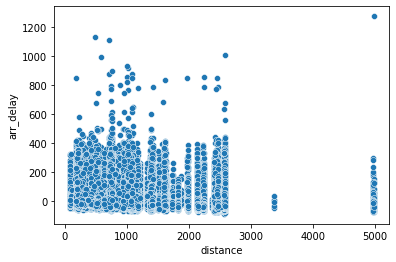

In [5]:
import seaborn as sns

sns.scatterplot(data=flights, x='distance', y='arr_delay');

# Outliers

What's the cause of the two outliers?

In [6]:
# Simple distance filter -- looks like HNL is frequently appearing
flights[flights['distance'] > 3000]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
162,2013,1,1,857.0,900,-3.0,1516.0,1530,-14.0,HA,51,N380HA,JFK,HNL,659.0,4983,9,0,2013-01-01 09:00:00
379,2013,1,1,1344.0,1344,0.0,2005.0,1944,21.0,UA,15,N76065,EWR,HNL,656.0,4963,13,44,2013-01-01 13:00:00
1073,2013,1,2,909.0,900,9.0,1525.0,1530,-5.0,HA,51,N380HA,JFK,HNL,638.0,4983,9,0,2013-01-02 09:00:00
1293,2013,1,2,1344.0,1344,0.0,1940.0,1944,-4.0,UA,15,N77066,EWR,HNL,634.0,4963,13,44,2013-01-02 13:00:00
2018,2013,1,3,914.0,900,14.0,1504.0,1530,-26.0,HA,51,N380HA,JFK,HNL,616.0,4983,9,0,2013-01-03 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334536,2013,9,28,1327.0,1329,-2.0,1710.0,1813,-63.0,UA,15,N66057,EWR,HNL,562.0,4963,13,29,2013-09-28 13:00:00
335095,2013,9,29,957.0,1000,-3.0,1405.0,1445,-40.0,HA,51,N384HA,JFK,HNL,580.0,4983,10,0,2013-09-29 10:00:00
335301,2013,9,29,1420.0,1329,51.0,1817.0,1813,4.0,UA,15,N66057,EWR,HNL,569.0,4963,13,29,2013-09-29 13:00:00
336081,2013,9,30,959.0,1000,-1.0,1438.0,1445,-7.0,HA,51,N392HA,JFK,HNL,603.0,4983,10,0,2013-09-30 10:00:00


In [7]:
# Q: Outliers?  A: Two outliers are Hawaii & Alaska
flights[flights['distance'] > 3000]['dest'].unique()

array(['HNL', 'ANC'], dtype=object)

In [8]:
# Create a new dataset without the outliers
flights2 = flights[flights['distance'] < 3000]

flights2.shape

(336061, 19)

# Look at the distribution of the data

* There are over 300K flights
* If there's a relationship, it's not clear from the scatterplot

# Some more insight

* You can get a better look at the data with 2-D histograms.
* [Seaborn joint histogram](https://seaborn.pydata.org/examples/joint_histogram.html)
* Vary the threshold "pmax" (between 0 and 1)

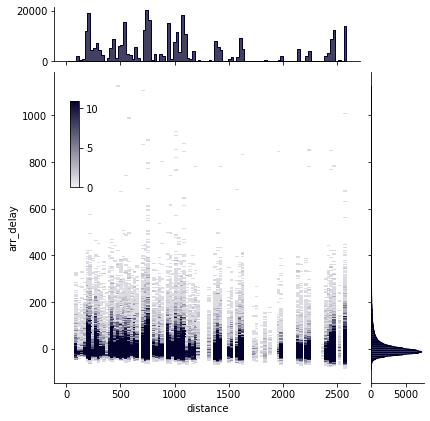

In [10]:
g = sns.JointGrid(data=flights2, x="distance", y="arr_delay", marginal_ticks=True)
cax = g.fig.add_axes([.15, .55, .02, .2]) # left, bottom, width, height
g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.1, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d");

# Group by destination

* How about delay vs distance, grouped by destination?
* Ref: [3.08 Aggregation and Grouping](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb) (VanderPlas) -- github
* GROUP BY is a SQL command, but it's also a split, apply, combine method in Pandas (and R)
* [Seaborn linear regression](https://seaborn.pydata.org/tutorial/regression.html)
* Compare [Chapter 5.6 Grouped Summaries](https://r4ds.had.co.nz/transform.html#grouped-summaries-with-summarise) of "R for Data Science"

In [11]:
grouped = flights2.groupby("dest")

aves = grouped.mean()
counts = grouped.size()

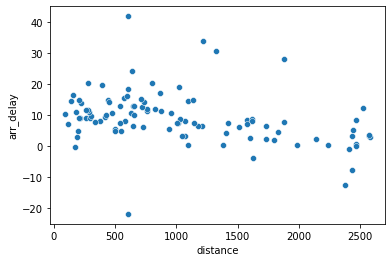

In [12]:
sns.scatterplot(data = aves, x = 'distance', y = 'arr_delay');